In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [7]:
def grad_cos(x):
    x = x.clone()
    x.requires_grad_(True)
    
    f = torch.max(torch.abs(x))
    f.backward()
    return x.grad

In [9]:
grad_cos(torch.tensor([1.,2.,3.]))

tensor([0., 0., 1.])

In [10]:
import os
print(os.listdir("input"))

['resnet_data', 'seg_pred', 'seg_test', 'seg_train']


In [11]:
os.chdir("input")


In [12]:
os.listdir()

['resnet_data', 'seg_pred', 'seg_test', 'seg_train']

In [13]:
import torch
from torch import nn
from torchvision import datasets, models, transforms

In [14]:
data_path_format = '../input/seg_{0}'

In [15]:
np.random.seed(5315)
torch.manual_seed(9784)

In [16]:
channel_means = (0.485, 0.456, 0.406)
channel_stds = (0.229, 0.224, 0.225)

In [17]:
image_transforms = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize(channel_means, channel_stds)
])

In [18]:
image_datasets = dict(zip(('dev', 'test'), [datasets.ImageFolder(data_path_format.format(key),transform=image_transforms) for key in ['train', 'test']]))
print(image_datasets)

{'dev': Dataset ImageFolder
    Number of datapoints: 14034
    Root location: ../input/seg_train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           ), 'test': Dataset ImageFolder
    Number of datapoints: 3000
    Root location: ../input/seg_test
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )}


In [19]:
devset_indices = np.arange(len(image_datasets['dev']))
devset_labels = image_datasets['dev'].targets

In [20]:
from sklearn import model_selection

In [21]:
train_indices, val_indices, train_labels,  val_labels = model_selection.train_test_split(devset_indices, devset_labels, test_size=0.1, stratify=devset_labels)

In [22]:
import torch.utils.data as tdata

In [23]:
image_datasets['train'] = tdata.Subset(image_datasets['dev'], train_indices)
image_datasets['validation'] = tdata.Subset(image_datasets['dev'], val_indices)

In [24]:
print(image_datasets)

{'dev': Dataset ImageFolder
    Number of datapoints: 14034
    Root location: ../input/seg_train
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           ), 'test': Dataset ImageFolder
    Number of datapoints: 3000
    Root location: ../input/seg_test
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           ), 'train': <torch.utils.data.dataset.Subset object at 0x000002574A3F9D90>, 'validation': <torch.utils.data.dataset.Subset object at 0x000002574A3F9E20>}


In [25]:
from IPython.display import display

In [26]:
image_dataloaders = {key: tdata.DataLoader(image_datasets[key], batch_size=16,shuffle=True) for key in  ['train', 'validation']}

In [27]:
image_dataloaders['test'] = tdata.DataLoader(image_datasets['test'], batch_size=32)

In [28]:
def imshow(inp, title=None, fig_size=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # C x H x W  # H x W x C
    inp = channel_stds * inp + channel_means
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.set_aspect('equal')
    plt.pause(0.001)  

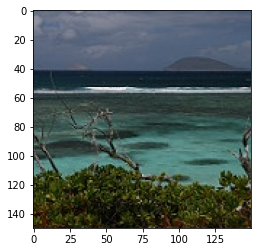

In [29]:
imshow(image_datasets['train'][8555][0])

In [30]:
cuda_device = torch.device('cuda')
cpu_device = torch.device('cpu')
device = cpu_device

In [31]:
import torch.nn as nn

In [32]:
import torch.nn as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 3, 5)
        self.relu1 = F.ReLU()
        self.fc1 = nn.Linear(3 * 69 * 69, 150)
        self.relu2 = F.ReLU()
        self.fc2 = nn.Linear(150, 84)
        self.relu3 = F.ReLU()
        self.fc3 = nn.Linear(84, 8)
        self.relu4 = F.ReLU()
    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.relu1(self.conv2(x))
        #x = x.view(16, -1, 6,  150)
        x = x.view(x.size(0), 3 * 69 * 69)
        x = self.relu2(self.fc1(x))
        x = self.relu3(self.fc2(x))
        x = self.relu4(self.fc3(x))
        return x

In [33]:
ptr = Net()
  
    
    
ptr = ptr.to(device)

In [34]:
class BestModel:
    def __init__(self, path, initial_criterion):
        self.path = path
        self.criterion = initial_criterion
        
    def update(self, model, optimizer, criterion):
        self.criterion = criterion
        torch.save({'model_state': model.state_dict(), 'optimizer_state': optimizer.state_dict(), 'criterion': criterion}, self.path)
        
    def load_model_data(self):
        return torch.load(self.path)
    
    def restore(self, model, optimizer):
        model_data = self.load_model_data()
        model.load_state_dict(model_data['model_state'])
        optimizer.load_state_dict(model_data['optimizer_state'])

In [35]:
def train_model(epochs, model, optimizer, criterion, loaders, device, best_model, n_prints=1):
    print_every = len(loaders['train']) // n_prints
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        
        for iteration, (xx, yy) in enumerate(loaders['train']):
            optimizer.zero_grad()
            xx, yy = xx.to(device), yy.to(device)
            out = model(xx)
            loss = criterion(out, yy)
            running_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            if(iteration % print_every == print_every - 1):
                running_train_loss /= print_every
                print(f"Epoch {epoch}, iteration {iteration} training_loss {running_train_loss}")
                running_train_loss = 0.0
            
        with torch.no_grad():
            model.eval()
            running_corrects = 0
            running_total = 0
            running_loss = 0.0
            for xx, yy in loaders['validation']:
                batch_size = xx.size(0)
                xx, yy = xx.to(device), yy.to(device)

                out = model(xx)
                
                loss = criterion(out, yy)
                running_loss += loss.item()
                
                predictions = out.argmax(1)
                running_corrects += (predictions == yy).sum().item()
                running_total += batch_size
            
            mean_val_loss = running_loss / len(loaders['validation'])
            accuracy = running_corrects / running_total
            
            if accuracy > best_model.criterion:
                best_model.update(model, optimizer, accuracy)
            
            print(f"Epoch {epoch}, val_loss {mean_val_loss}, accuracy = {accuracy}")
    best_model.restore(model, optimizer)

In [36]:
import time
start = time.time()

In [37]:
optimizer = torch.optim.Adam(ptr.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()
best_model = BestModel('resnet_data',0.0)
train_model(10, ptr, optimizer, criterion,image_dataloaders, device, best_model=best_model, n_prints=5)

Epoch 0, iteration 157 training_loss 1.637183066787599
Epoch 0, iteration 315 training_loss 1.2196446464786046
Epoch 0, iteration 473 training_loss 1.1342651745941066
Epoch 0, iteration 631 training_loss 1.0866079104097583
Epoch 0, iteration 789 training_loss 1.037771767830547
Epoch 0, val_loss 0.9856443039395593, accuracy = 0.6246438746438746
Epoch 1, iteration 157 training_loss 0.9640112579623356
Epoch 1, iteration 315 training_loss 0.948017570036876
Epoch 1, iteration 473 training_loss 0.9193070374334915
Epoch 1, iteration 631 training_loss 0.9347649393956873
Epoch 1, iteration 789 training_loss 0.9299092511587506
Epoch 1, val_loss 0.9460395615209233, accuracy = 0.6374643874643875
Epoch 2, iteration 157 training_loss 0.8267903914557228
Epoch 2, iteration 315 training_loss 0.8296318621952322
Epoch 2, iteration 473 training_loss 0.8552671610554562
Epoch 2, iteration 631 training_loss 0.8336119510327713
Epoch 2, iteration 789 training_loss 0.8353456562455697
Epoch 2, val_loss 0.8751914

In [38]:
end = time.time()
print(end - start)

1187.4218261241913


In [48]:
from torchvision.utils import make_grid

In [49]:
xx, yy = next(iter(image_dataloaders['validation']))

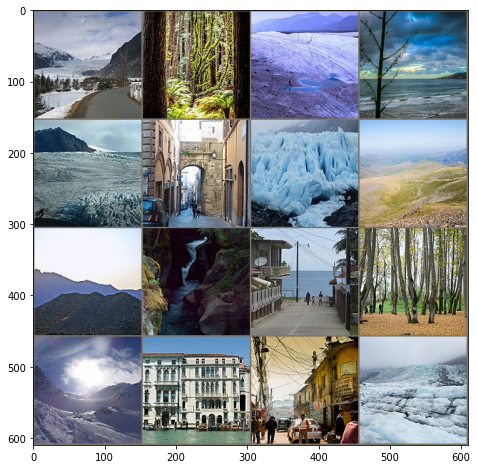

['glacier', 'forest', 'sea', 'glacier', 'glacier', 'street', 'sea', 'sea', 'mountain', 'street', 'street', 'forest', 'sea', 'buildings', 'buildings', 'glacier']
['glacier', 'forest', 'glacier', 'sea', 'glacier', 'street', 'glacier', 'mountain', 'mountain', 'glacier', 'street', 'forest', 'glacier', 'buildings', 'street', 'glacier']


In [50]:
ptr.eval()
out = ptr(xx.cpu())
preds = out.argmax(1)
predicted_classes = [image_datasets['dev'].classes[c] for c in preds]
actual_classes = [image_datasets['dev'].classes[c] for c in yy]
imshow(make_grid(xx, nrow=4), fig_size=(8,8))
print(predicted_classes)
print(actual_classes)

In [51]:
all_preds = []
correct_preds = []
with torch.no_grad():
    ptr.eval()
    for xx, yy in image_dataloaders['test']:
        xx = xx.to(device)
        output = ptr(xx)
        all_preds.extend(output.argmax(1).tolist())
        correct_preds.extend(yy.tolist())

In [52]:
from sklearn import metrics

In [53]:
all_preds = np.asarray(all_preds)
correct_preds = np.asarray(correct_preds)

In [54]:
target_names = image_datasets['test'].classes
print(metrics.classification_report(correct_preds, all_preds,target_names=target_names))

              precision    recall  f1-score   support

   buildings       0.57      0.54      0.55       437
      forest       0.89      0.79      0.83       474
     glacier       0.66      0.66      0.66       553
    mountain       0.66      0.66      0.66       525
         sea       0.57      0.51      0.54       510
      street       0.64      0.80      0.71       501

    accuracy                           0.66      3000
   macro avg       0.66      0.66      0.66      3000
weighted avg       0.66      0.66      0.66      3000



In [55]:
confusion_matrix = metrics.confusion_matrix(correct_preds, all_preds)
pd.DataFrame(confusion_matrix, index=target_names, columns=target_names)

,buildings,forest,glacier,mountain,sea,street
buildings,234,12,24,28,37,102
forest,16,374,0,2,0,82
glacier,33,0,366,59,76,19
mountain,41,5,48,349,77,5
sea,45,1,102,89,260,13
street,42,30,15,5,9,400
